In [1]:
import re
import string
import itertools

import nltk
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from scipy import stats

## Data Loading

In [2]:
df = pd.concat([
    pd.read_json("../data/clean/lkpp-products-ready.jsonl", lines=True),
    pd.read_json("../data/clean/ecom-products-ready.jsonl", lines=True),
], ignore_index=True)

df["id"] = df["id"].astype(str)
df = df.drop_duplicates(subset=["id"])

df.head()

,id,product_name,source,price,series_model,brand,processor,memory_gb,storage_gb,storage_type,graphics_card
0,83451581,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,LKPP,12500000,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,AXIOO,Intel Core I5- 3.70 GHz - Frekuensi Turbo | Co...,8.0,NaN,SSD NVME,Integrated
16,84521755,ACER LAPTOP TRAVELMATE P214 CORE I5/8 GB/512 G...,LKPP,18300000,TravelMate P214,ACER,Intel Core i5-1335U,8.0,512.0,HDD,Integrated
32,84521452,ACER LAPTOP TRAVELMATE P214 CORE I3/8 GB/512 G...,LKPP,15070000,Travelmate P214,ACER,Intel Core i3-1315U,8.0,512.0,HDD,Integrated
41,83971989,AXIOO LAPTOP MYBOOK PRO CORE I5 L5 (8N5),LKPP,18100000,MyBook Pro L5 (8N5),AXIOO,Intel Core i5-1235U,8.0,512.0,HDD,Integrated
57,80375727,AXIOO LAPTOP MYBOOK 14F,LKPP,3999000,MyBook 14F,AXIOO,Intel Celeron N4020 (1.10 GHz; 4M Cache; up to...,6.0,256.0,SSD,Integrated


In [3]:
df.to_json("../data/clean/combined.jsonl", orient="records", lines=True)

## Preprocess

<Axes: >

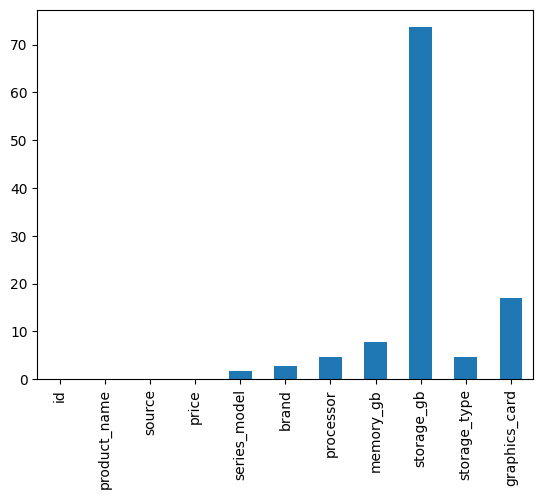

In [3]:
dd = df.isna().sum() / df.shape[0] * 100
dd.plot.bar()

In [4]:
df = df.dropna(subset=["processor", "memory_gb"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20224 entries, 0 to 22365
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20224 non-null  object 
 1   product_name   20224 non-null  object 
 2   source         20224 non-null  object 
 3   price          20224 non-null  int64  
 4   series_model   20208 non-null  object 
 5   brand          20171 non-null  object 
 6   processor      20224 non-null  object 
 7   memory_gb      20224 non-null  float64
 8   storage_gb     5754 non-null   float64
 9   storage_type   19999 non-null  object 
 10  graphics_card  17494 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.9+ MB


<Axes: xlabel='source'>

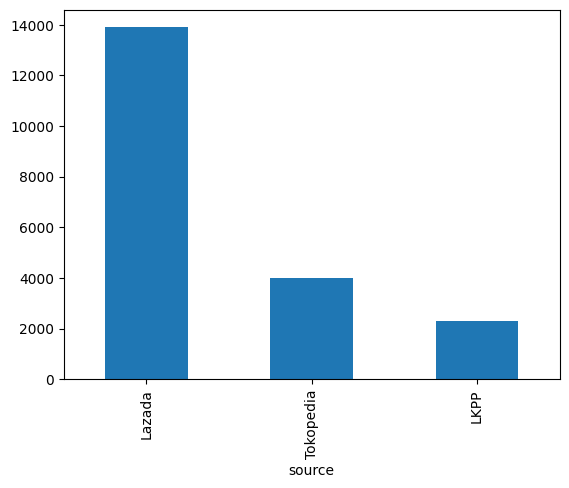

In [5]:
df["source"].value_counts().plot.bar()

## Keyword Research

In [6]:
def clean_tokenize_product_name(s: str):
    if s is None: 
        return []
    
    # case folding
    text = s.lower()

    # punctuation removal
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    return nltk.tokenize.word_tokenize(text)

def get_ngram_frame(corpus: list[str], n_gram=2):
    product_name_corpus = list(itertools.chain(*[clean_tokenize_product_name(x) for x in corpus]))
    product_name_grams = list(nltk.ngrams(product_name_corpus, n_gram))

    fdist = nltk.FreqDist(product_name_grams)
    gram_df = pd.DataFrame({
        "gram": [" ".join(x) for x in fdist.keys()],
        "freq": [x for x in fdist.values()]
    })

    return gram_df.sort_values("freq", ascending=False)

In [19]:
N_GRAM = 1
gram_df = get_ngram_frame(df[df["source"] == "LKPP"]["series_model"].values, N_GRAM)
gram_df.head()

,gram,freq
6,mybook,678
7,pro,659
24,expertbook,478
524,bg1408cva,378
31,chromebook,187


Text(0.5, 1.0, 'Top 20 1-gram of Product Name')

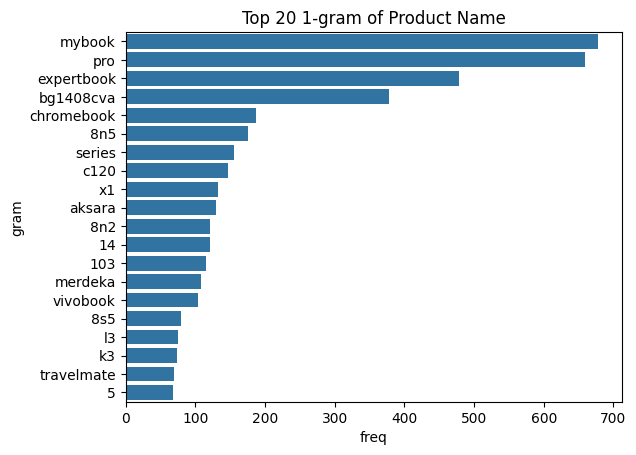

In [20]:
sns.barplot(gram_df.nlargest(20, "freq"), x="freq", y="gram")
plt.title(f"Top 20 {N_GRAM}-gram of Product Name")

In [31]:
df[df["product_name"].str.contains("MYBOOK.+L5", regex=True, flags=re.IGNORECASE)]

,id,product_name,source,price,series_model,brand,processor,memory_gb,storage_gb,storage_type,graphics_card
41,83971989,AXIOO LAPTOP MYBOOK PRO CORE I5 L5 (8N5),LKPP,18100000,MyBook Pro L5 (8N5),AXIOO,Intel Core i5-1235U,8.0,512.0,HDD,Integrated
42,83971989,AXIOO LAPTOP MYBOOK PRO CORE I5 L5 (8N5),LKPP,18100000,MyBook Pro L5 (8N5),AXIOO,Intel Core i5-1235U,8.0,512.0,HDD,Integrated
43,83971989,AXIOO LAPTOP MYBOOK PRO CORE I5 L5 (8N5),LKPP,18100000,MyBook Pro L5 (8N5),AXIOO,Intel Core i5-1235U,8.0,512.0,HDD,Integrated
44,83971989,AXIOO LAPTOP MYBOOK PRO CORE I5 L5 (8N5),LKPP,18100000,MyBook Pro L5 (8N5),AXIOO,Intel Core i5-1235U,8.0,512.0,HDD,Integrated
45,83971989,AXIOO LAPTOP MYBOOK PRO CORE I5 L5 (8N5),LKPP,18100000,MyBook Pro L5 (8N5),AXIOO,Intel Core i5-1235U,8.0,512.0,HDD,Integrated
...,...,...,...,...,...,...,...,...,...,...,...
17645,031cb2c1e1d0406c9e9f058d9c32e58e909bc6d1aa06ea...,LAPTOP AXIOO MYBOOK PRO L5 (8N2-5) i5 8GB 256G...,Lazada,14913000,MyBook Pro L5,AXIOO,Intel Core i5-1235U,8.0,256.0,SSD NVME,Integrated
17655,621d164e1c5a4636f138385c64882b3b9efb88b7ea3551...,Axioo MyBook Pro L5 (8N9) 14 Inch i5-1135G7 8G...,Lazada,18560000,MyBook Pro L5 (8N9),AXIOO,i5-1135G7,8.0,NaN,SSD,Integrated
17656,bba7c8827e7b0ff990cb7191d0a7ba4862619d4cb5a91c...,NOTEBOOK AXIOO MYBOOK PRO L5 (8N9) RAM 8GB/ 1T...,Lazada,16000000,MyBook Pro L5 (8N9),AXIOO,Intel Core i5-1235U,8.0,NaN,SSD NVME,Integrated
17666,2a4575da5cedc26dfdf6f340dbaa042154b9171e298b3d...,NOTEBOOK AXIOO MYBOOK PRO L5 (8N2) RAM 8GB/ 25...,Lazada,15000000,MyBook Pro L5 (8N2),AXIOO,Intel Core i5-1235U,8.0,256.0,SSD NVME,Integrated


## Compare Prices

In [61]:
subset_df = df[df["product_name"].str.contains("C120", regex=True, flags=re.IGNORECASE)]
subset_df.head()

,id,product_name,source,price,series_model,brand,processor,memory_gb,storage_gb,storage_type,graphics_card
244,75898191,LIBERA LIBERA MERDEKA CHROMEBOOK C120 1Y (HANY...,LKPP,6950000,Chromebook C120 1Y,LIBERA,"OctaCore up to 2.4Ghz, Cache 2MB",4.0,32.0,HDD,Integrated
245,75898191,LIBERA LIBERA MERDEKA CHROMEBOOK C120 1Y (HANY...,LKPP,6950000,Chromebook C120 1Y,LIBERA,"OctaCore up to 2.4Ghz, Cache 2MB",4.0,32.0,HDD,Integrated
246,75898191,LIBERA LIBERA MERDEKA CHROMEBOOK C120 1Y (HANY...,LKPP,6950000,Chromebook C120 1Y,LIBERA,"OctaCore up to 2.4Ghz, Cache 2MB",4.0,32.0,HDD,Integrated
247,75898191,LIBERA LIBERA MERDEKA CHROMEBOOK C120 1Y (HANY...,LKPP,6950000,Chromebook C120 1Y,LIBERA,"OctaCore up to 2.4Ghz, Cache 2MB",4.0,32.0,HDD,Integrated
248,75898191,LIBERA LIBERA MERDEKA CHROMEBOOK C120 1Y (HANY...,LKPP,6950000,Chromebook C120 1Y,LIBERA,"OctaCore up to 2.4Ghz, Cache 2MB",4.0,32.0,HDD,Integrated


<Axes: xlabel='source'>

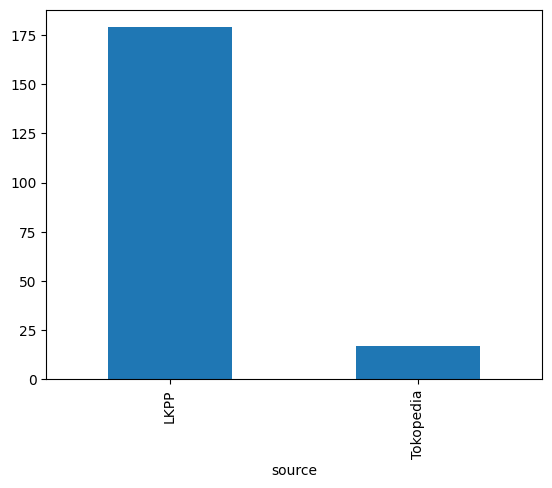

In [62]:
subset_df["source"].value_counts().plot.bar()

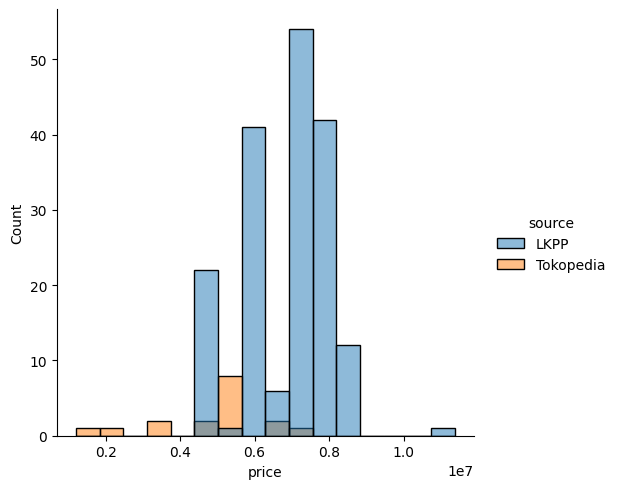

In [63]:
sns.displot(subset_df, x="price", hue="source")

In [64]:
fig = px.histogram(subset_df, x="price", color="source", marginal="box")
fig.update_layout(barmode="overlay")
fig.update_traces(opacity=0.75)
fig.show()

In [65]:
subset_df.groupby("source")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
LKPP,179.0,6.786685e+06,1.121127e+06,5000000.0,5750000.0,6950000.0,7650000.0,11378610.0
Tokopedia,17.0,4.844294e+06,1.585248e+06,1200000.0,4560000.0,5250000.0,5350000.0,7110000.0


In [66]:
stats.ttest_ind(subset_df[subset_df["source"] == "LKPP"]["price"], subset_df[subset_df["source"] == "Tokopedia"]["price"])

TtestResult(statistic=np.float64(6.561557249874629), pvalue=np.float64(4.73150515004561e-10), df=np.float64(194.0))

In [67]:
stats.ttest_1samp(subset_df["price"], 4750000)

TtestResult(statistic=np.float64(20.337391791033042), pvalue=np.float64(4.411184041990669e-50), df=np.int64(195))